# hopefully you're here to make improvements 🤪

demonstration of using the ANKLES.py script.

Note, you should be able to train new SBI models and call them by their paths in the `ANKLES.sample_posterior()` function.

In [201]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.stats as stats
from torch.distributions import Distribution
from sklearn.neighbors import KernelDensity
import torch
import pandas as pd

from tqdm import tqdm
from sbi.inference import SNPE
from sbi.neural_nets import posterior_nn
from sbi.utils import BoxUniform
# from sbi.inference import load_posterior


plt.rcParams.update({
    'figure.figsize':(7,7),
    'xtick.major.width':1,
    'ytick.major.width':1,
    'xtick.minor.width':1,
    'ytick.minor.width':1,
    'xtick.major.size':8,
    'ytick.major.size': 6,
    'xtick.minor.size':3,
    'ytick.minor.size':3,
    'font.family':'STIXGeneral',
    'font.size':16,
#    'xtick.top':True,
#    'ytick.right':True,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'mathtext.fontset': 'cm',
    'mathtext.rm': 'serif'})   

def make_plot_nice(ax):
    """
    """    
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')  # or 'bottom'                                                    
    ax.tick_params(direction='in',axis='both',which='minor',length=3,width=1,labelsize=14)
    ax.tick_params(direction='in',axis='both',which='major',length=6,width=1,labelsize=14)
    ax.minorticks_on()  
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.)

    return

from sklearn.model_selection import train_test_split

import seaborn as sns

import itertools
from matplotlib.lines import Line2D
import random

import astropy.constants as const
import astropy.units as u

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
from torch.distributions import constraints

import corner

import ANKLES

from priors import KDEPrior ### must be in this notebook for  SBI to run!!

The script will let us generate an RV curve based on the prior the model was trained on (i.e. distribution of model parameters in the training dataset)

100%|██████████| 1/1 [00:00<00:00, 848.02it/s]


[13428.12496796]


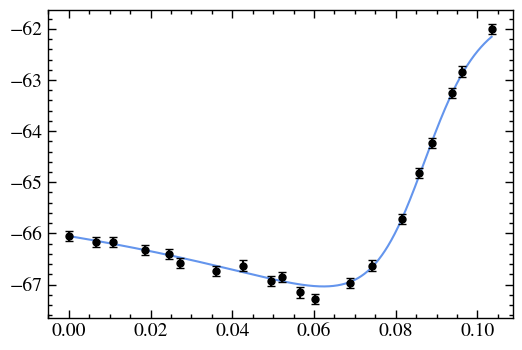

In [208]:
# generate an example system

RVs, obsTimes, params = ANKLES.generate_simulated_data(1)
v0, K, w, phi0, e, logP = params.numpy().T
P = 10**logP
# K
phases = ANKLES.compute_phase(obsTimes[0], P)
t_model = np.linspace(0, max(obsTimes[0]), 1000)
v_model = ANKLES.radial_velocity(t_model, params.numpy().T)
phase_model = ANKLES.compute_phase(t_model, P=P, T0=obsTimes[0][0])
sort_idx = np.argsort(phase_model)
phase_model = phase_model[sort_idx]
rv_model = v_model[sort_idx]



fig, ax = plt.subplots(figsize=[6,4])
ax.plot(phase_model, rv_model, c='cornflowerblue', zorder=0)
ax.errorbar(phases, RVs[0], yerr=0.1, marker='o', linestyle='', markersize=5, capsize=3, c='k')
make_plot_nice(ax)
print(P)

Get the input data together, a concatenated array of 20 RVs, 20 observation epochs, then use `ANKLES.sample_posterior()` to generate posterior samples for a corner plot...

In [209]:
input_data = np.concat([RVs[0], obsTimes[0]])

In [210]:
# generate posterior samples

samples = ANKLES.sample_posterior(np.array([input_data]), n_samples=100000, model_path='models/sbi_model_longtraining.pt')

Drawing 100000 posterior samples: 100%|██████████| 100000/100000 [00:00<00:00, 117932.61it/s]


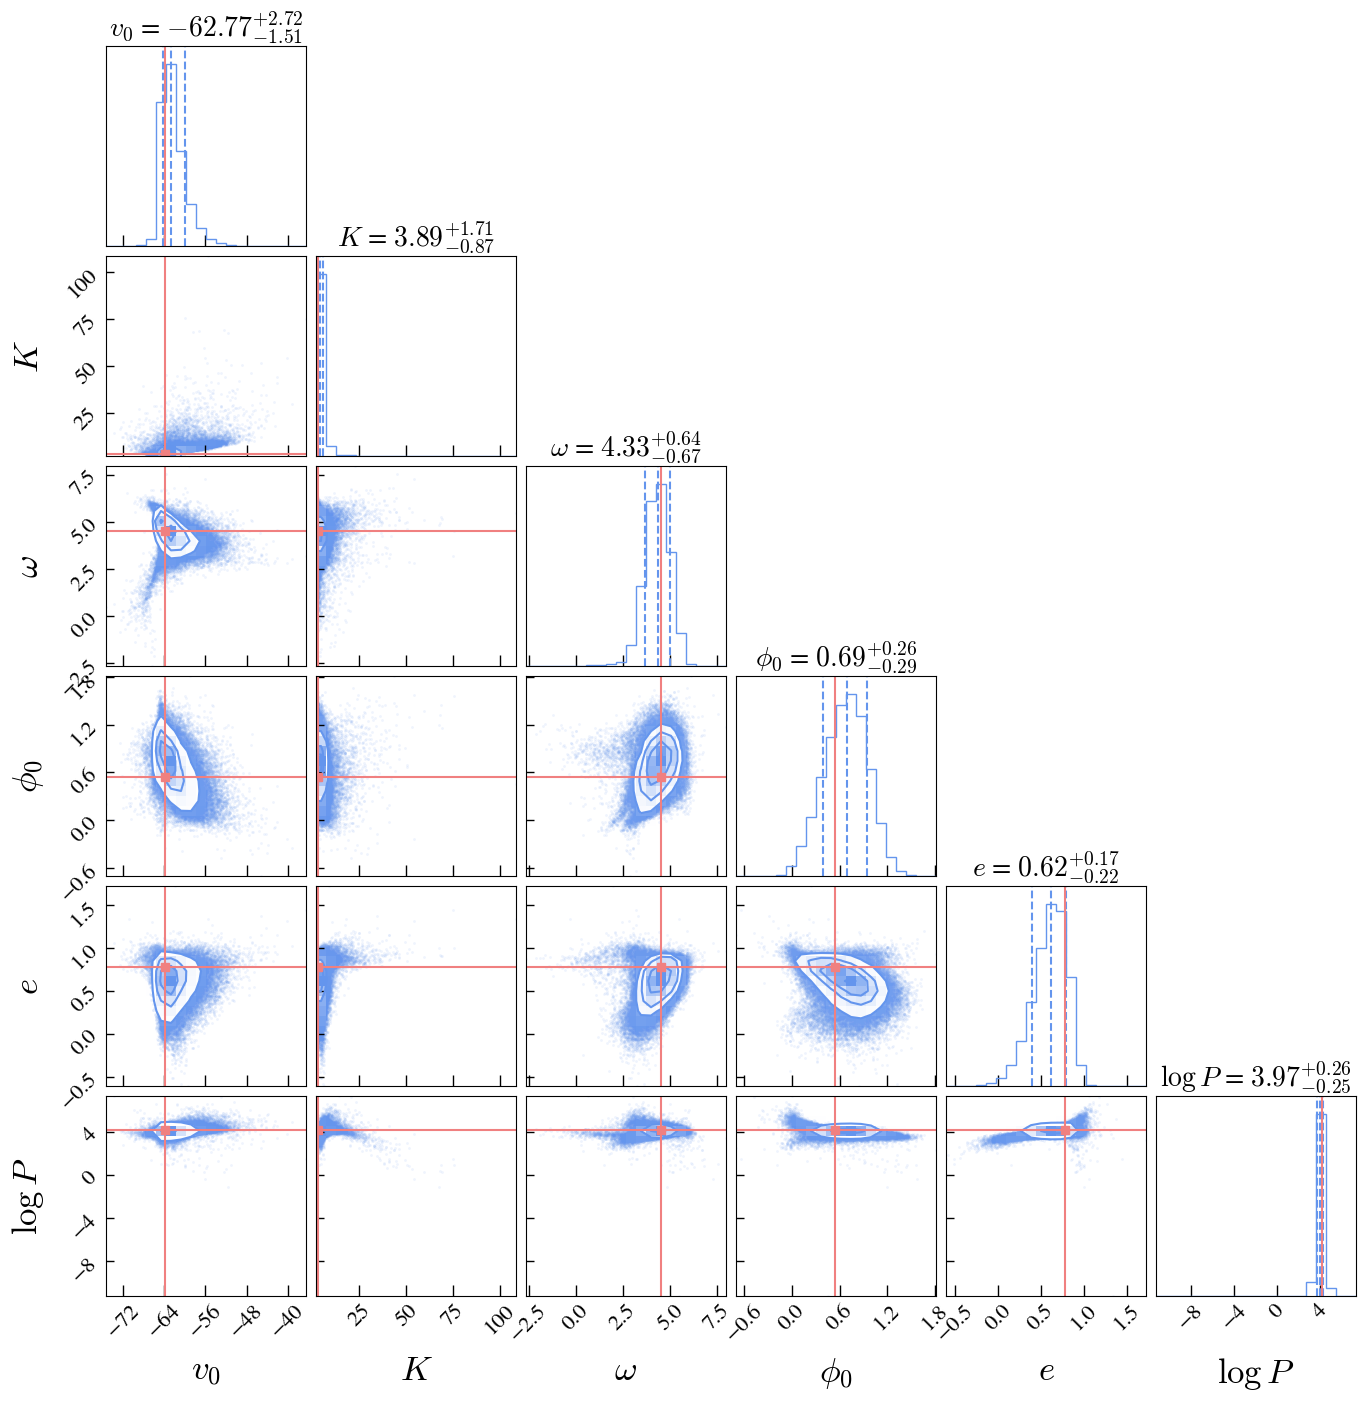

In [211]:
# a corner plot of the samples 
param_names = [r'$v_0$', r'$K$', r'$\omega$', r'$\phi_0$', r'$e$', r'$\log{P}$']

# Plot using corner
# with plt.style.context("dark_background"):

figure = corner.corner(samples,
                    labels=param_names,
                    truths=params[0].numpy(), 
                    color="cornflowerblue",#'#CD533B',
                    truth_color='lightcoral',
                    show_titles=True,
                    title_fmt='.2f',
                    quantiles=[0.16, 0.5, 0.84],
                    title_kwargs={"fontsize": 20},
                    label_kwargs={"fontsize":25})

Finally, plot the RV curve with the true model and several samples from the posterior overlayed

Drawing 30 posterior samples: 100%|██████████| 30/30 [00:00<00:00, 5051.55it/s]


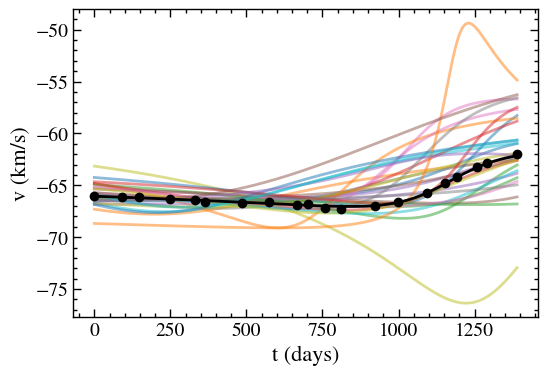

In [220]:
# plot an RV curve and overlay sample models from the posterior

fig, ax = plt.subplots(figsize=[6,4])

true_params = params[0].numpy()
rvs = RVs[0]
ts = obsTimes[0]

samples = ANKLES.sample_posterior(np.array([input_data]), n_samples=30)

for sample in samples:
    t_model = np.linspace(0, max(ts), 100000)
    v_samp = ANKLES.radial_velocity(t_model, sample, logP=True)

    ax.plot(t_model, v_samp, lw=2, alpha=0.5)
v_model = ANKLES.radial_velocity(t_model, params.numpy().T)
ax.plot(t_model, v_model, c='k', lw=2)
ax.errorbar(ts, rvs, yerr=0.1, marker='o', color='k', linestyle='', capsize=3)
# ax.set_xlim(0, 250)
ax.set_xlabel("t (days)")
ax.set_ylabel('v (km/s)')
make_plot_nice(ax)

huh...looks kind of bad!